In [40]:
import torch
from llm_toolkit.llm import LLM

llm = LLM("unsloth/Llama-3.2-1B-Instruct")
inputs = llm.tokenizer("This is my test, yes, my very test.", return_tensors="pt")
print(f"Inputs: {inputs['input_ids'].shape}")
with torch.no_grad():
    outputs = llm.model.generate(inputs.input_ids, 
                                    output_hidden_states=True, 
                                    return_dict_in_generate=True, 
                                    max_new_tokens=10, 
                                    min_new_tokens=10, 
                                    pad_token_id=llm.tokenizer.pad_token_id)
    

print("Number of output tokens?: ", len(outputs['hidden_states']))
print("Number of layers: ", len(outputs['hidden_states'][0]))
print("Number of layers: ", len(outputs['hidden_states'][1]))
print("Number of layers: ", len(outputs['hidden_states'][2]))
print("First token: ", outputs['hidden_states'][0][5].shape) # Layer 5 - contains all the tokens from input?
print("Second token: ", outputs['hidden_states'][1][5].shape) # Layer 5
print("Third token: ", outputs['hidden_states'][2][5].shape) # Layer 5
print("===")
print("First token: ", outputs['hidden_states'][0][5][0,0,:])
print("Second token: ", outputs['hidden_states'][0][5][0,1,:])




Inputs: torch.Size([1, 12])
Number of output tokens?:  10
Number of layers:  17
Number of layers:  17
Number of layers:  17
First token:  torch.Size([1, 12, 2048])
Second token:  torch.Size([1, 1, 2048])
Third token:  torch.Size([1, 1, 2048])
===
First token:  tensor([ 0.1540, -0.5038,  1.6057,  ..., -0.2343,  1.3638, -0.1373])
Second token:  tensor([ 0.0608, -0.1365, -0.1327,  ...,  0.0287, -0.0818, -0.0287])


In [41]:
import numpy as np


num_layers = len(outputs['hidden_states'][0])  # Number of layers
sequence_length = outputs['hidden_states'][0][0].shape[1]  # Sequence length
embedding_dim = outputs['hidden_states'][0][0].shape[2]  # Embedding dimension

embeddings = np.zeros((num_layers, sequence_length, embedding_dim))

token_index_list: list[str] = []
# Iterate over each layer and token to extract embeddings
for token_index in range(sequence_length):
    for layer_index in range(num_layers):
        embeddings[layer_index, token_index, :] = outputs['hidden_states'][0][layer_index][0, token_index, :].detach().numpy()
        token_index_list.append(token_index)


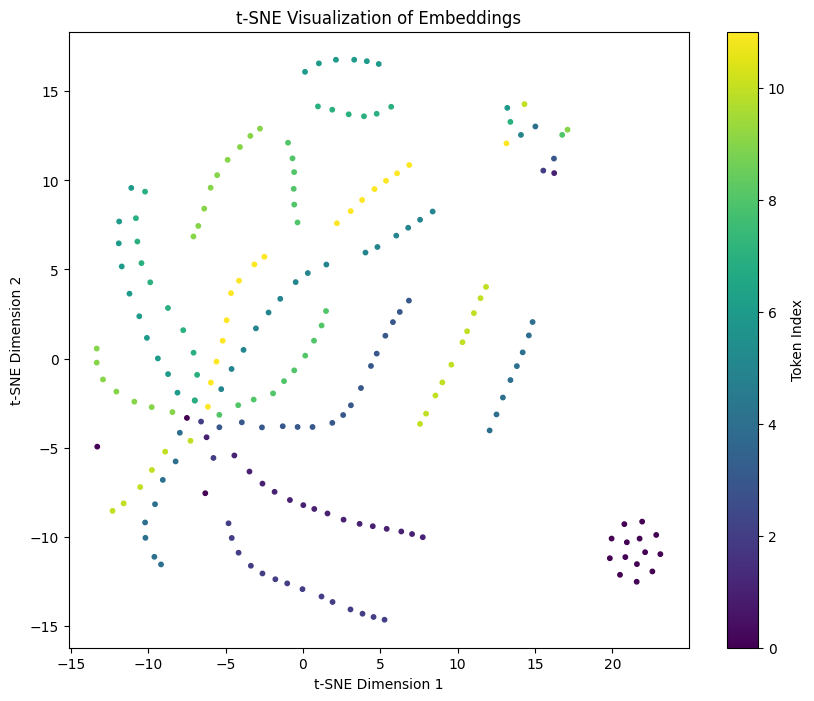

In [42]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt


# Computing t-SNE
flattened_embeddings = embeddings.reshape(-1, embedding_dim)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)

tsne_results = tsne.fit_transform(flattened_embeddings)
# Extracting token indices for coloring
token_index_list = np.tile(np.arange(sequence_length), num_layers)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=token_index_list, cmap='viridis', s=10)
plt.colorbar(scatter, label="Token Index")
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

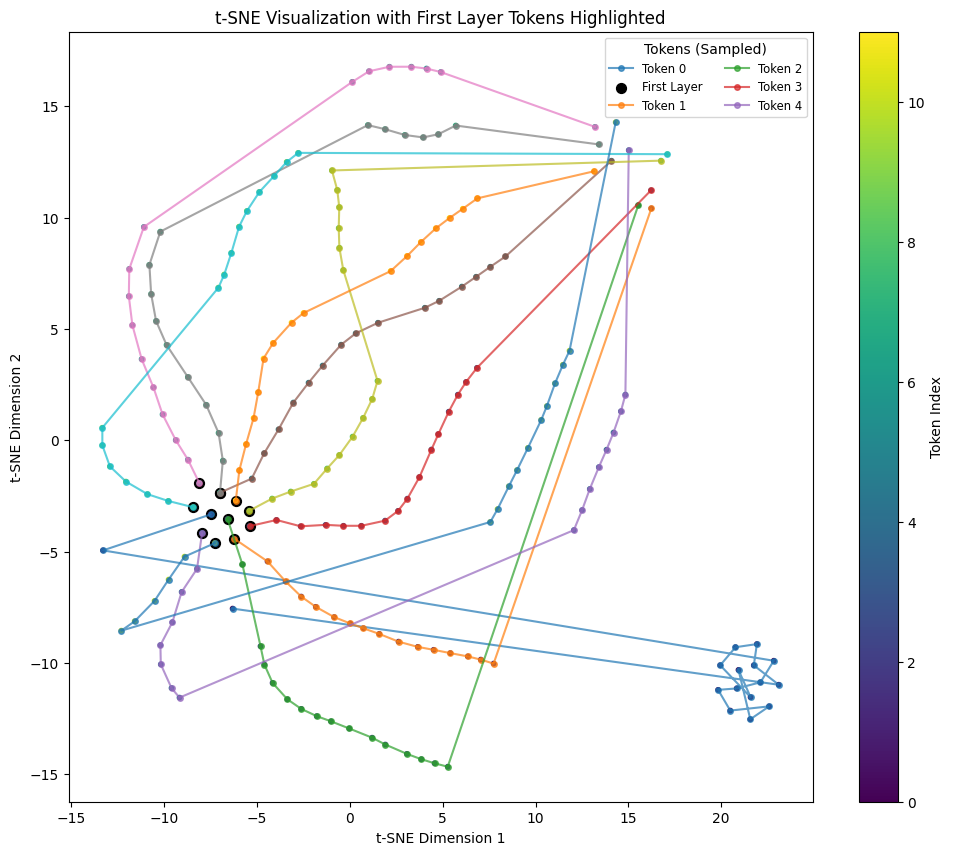

In [43]:
# Plotting the t-SNE results with the first layer's tokens in black and connecting consecutive layers for the same token
plt.figure(figsize=(12, 10))

for token_idx in range(sequence_length):
    # Extract points corresponding to the same token across all layers
    token_points = tsne_results[token_idx::sequence_length]
    
    # Plot line segments connecting the points
    plt.plot(
        token_points[:, 0],
        token_points[:, 1],
        marker='o',
        markersize=4,
        linestyle='-',
        alpha=0.7,
        label=f"Token {token_idx}" if token_idx < 5 else None  # Limit legend for clarity
    )
    
    # Highlight the first layer's point for the token in black
    plt.scatter(
        token_points[0, 0],
        token_points[0, 1],
        color='black',
        s=50,
        label="First Layer" if token_idx == 0 else None  # Add legend entry only once
    )

# Add scatter plot for individual points
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=token_index_list, cmap='viridis', s=10)

# Add colorbar and labels
plt.colorbar(scatter, label="Token Index")
plt.title("t-SNE Visualization with First Layer Tokens Highlighted")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(loc="best", fontsize='small', ncol=2, frameon=True, title="Tokens (Sampled)")
plt.show()
